<a href="https://colab.research.google.com/github/HyeongChanHam/hand_project/blob/master/topic_1_cross_validation(hold_out).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
env = 'colab'
if env=='colab':
    from google.colab import drive
    drive.mount('/content/gdrive')
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import numpy as np
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import models
from sklearn.model_selection import train_test_split # for cross-validation
from sklearn.model_selection import StratifiedKFold # for cross-validation
from glob import glob


In [ ]:
categories = ['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill',
              'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone',
              'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball',
              'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']
training_num_imgs = 30
val_split_ratio = 0.2 # validation
train_img_len = int(training_num_imgs * (1-val_split_ratio))
val_img_len = int(training_num_imgs * val_split_ratio)
test_img_len = 5
num_of_classes = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
len(train_indices[0]), len(val_indices[0])

(24, 6)

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, method=None, split_idxes=None):
        #self.root = '/content/gdrive/My Drive/'
        self.root = '/content/gdrive/My Drive/computer vision/'
        self.x_data = []
        self.y_data = []
        self.img_path = []

        assert split_idxes is not None

        if method == 'train':
            length = train_img_len
            self.root = self.root + 'dataset/train'
            
        elif method == 'val':
            length = val_img_len
            self.root = self.root + 'dataset/train'

        else:
            length = test_img_len
            self.root = self.root + 'dataset/test'
        
        for cat_idx, category in tqdm(enumerate(categories), total=num_of_classes):
            dir_path = self.root + '/' + category + '/'
            for img_idx, img_p in enumerate(sorted(glob(dir_path + '*.jpg'))):
                if img_idx not in split_idxes[cat_idx]:
                    continue
                img = cv2.imread(img_p)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.x_data.append(img)
                self.y_data.append(cat_idx)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Resnet input tensor로 쓰기 위해 resize
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),                 
        ])
        new_x_data = transform1(self.x_data[idx])
        return new_x_data, self.y_data[idx]

    def return_whole(self):
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),                 
        ])
        new_x_data = []
        for i in range(train_img_len * num_of_classes):
            new_x_data.append(transform1(self.x_data[i]))

        return new_x_data, self.y_data

In [ ]:
class Trainer(object):
    def __init__(self, epochs, batch_size, lr):

        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        self._build_model()

        """
        split train_val idxes
        """
        indices = np.array([x for x in range(training_num_imgs)])
        train_indices = list()
        val_indices = list()
        for _ in range(num_of_classes):
            val_idx = np.random.choice(indices, val_img_len, replace=False)
            train_idx = np.setdiff1d(indices, val_idx)
            train_indices.append(train_idx)
            val_indices.append(val_idx)

        test_indices = [[x for x in range(test_img_len)] for _ in range(num_of_classes)]


        self.dataset = ImgDataset(method='train', split_idxes=train_indices)
        self.val_dataset = ImgDataset(method='val', split_idxes=val_indices)
        self.root = self.dataset.root
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        weight_PATH = self.root.split('/')
        del weight_PATH[-1]
        del weight_PATH[-1]
        
        self.weight_PATH = "/".join(weight_PATH)
        self.weight_PATH = self.weight_PATH + "/"
        print("weightPATH: ",self.weight_PATH)

        # Load of pretrained_weight file
        # weight_PATH = '/content/gdrive/My Drive/
        # self.poseNet.load_state_dict(torch.load(weight_PATH))

        print("Training...")

    def _build_model(self):
        net = models.resnet18(pretrained=True)

        """
        freeze feature extraction layers, except classifier
        """
        for p in net.parameters():
            p.requires_grad = False

        net.fc = torch.nn.Linear(in_features = net.fc.in_features, out_features=num_of_classes)

        self.resnet = net.to(device)
        self.resnet.train()

        print('Finish build model.')

    def return_whole_training_img(self):
        return self.dataset.return_whole()

    def train(self):
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.resnet.parameters(), lr=self.learning_rate)

        self.losses = []
        self.val_losses = []
        for epoch in tqdm(range(self.epochs + 1)):
            print("epoch ",epoch)
            train_loss = 0
            if epoch == self.epochs:
                 torch.save(self.resnet.state_dict(), "".join([self.weight_PATH,'modelweight.pth']))

            for batch_idx, samples in enumerate(self.dataloader):
                optimizer.zero_grad()
                x_train, y_train = samples
                x_train, y_train = x_train.to(device), y_train.to(device)
                result_resnet = self.resnet(x_train)

                loss = loss_func(result_resnet, y_train)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

            self.losses.append(train_loss/batch_idx)

            val_loss = 0
            for batch_idx, samples in enumerate(self.val_dataloader):
                x_train, y_train = samples
                x_train, y_train = x_train.to(device), y_train.to(device)
                result_resnet = self.resnet(x_train)

                loss = loss_func(result_resnet, y_train)
                val_loss += loss.item()

            self.val_losses.append(val_loss/batch_idx)
            print("training loss: {}, val loss: {}".format(train_loss/batch_idx, val_loss/batch_idx))
        print('Finish training.\n')
    
class Tester(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self._build_model()

        dataset = ImgDataset(method='test')
        self.root = dataset.root
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        self.datalen = dataset.__len__()
        self.correct = 0

        # load the weight
        weight_PATH = '/content/gdrive/My Drive/computer vision/dataset/modelweight.pth'
        self.resnet.load_state_dict(torch.load(weight_PATH))

        print("Testing...")

    def _build_model(self):
        net = models.resnet18(pretrained=True)

        """
        freeze feature extraction layers, except classifier
        """
        for p in net.parameters():
            p.requires_grad = False

        net.fc = torch.nn.Linear(in_features = net.fc.in_features, out_features=num_of_classes)

        self.resnet = net.to(device)
        self.resnet.eval()

        print('Finish build model.')

    def test(self):
        for batch_idx, samples in enumerate(self.dataloader):
            x_test, y_test = samples
            x_test, y_test = x_test.to(device), y_test.to(device)
        
            total = self.datalen


            #soft_func = nn.Softmax(dim=1)
            #output = soft_func(torch.FloatTensor(result_resnet))
            for i in range(self.batch_size):
              res = np.argmax(result_resnet[i])
              if res == y_test[i]:
                self.correct+=1
            
        print('total : ', total)
        print("Accuracy %f" %(self.correct/total))
                
# torch.cuda.isavailable

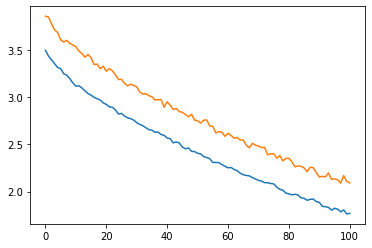

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='test_loss')
plt.title('lr=1e-4')
plt.legend()
plt.show()

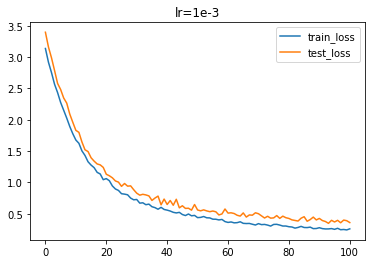

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='test_loss')
plt.title('lr=1e-3')
plt.legend()
plt.show()

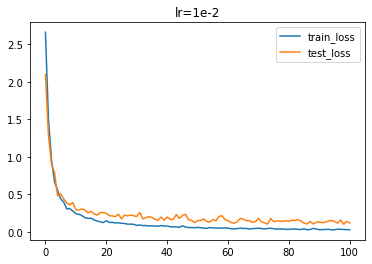

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='test_loss')
plt.title('lr=1e-2')
plt.legend()
plt.show()

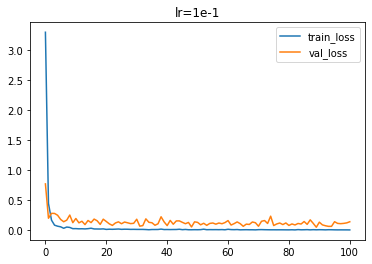

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title('lr=1e-1')
plt.legend()
plt.show()

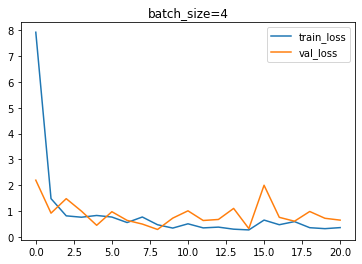

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title('batch_size=4')
plt.legend()
plt.show()

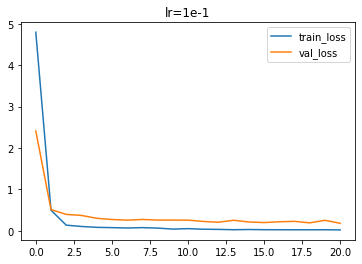

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title('batch_size=32')
plt.legend()
plt.show()

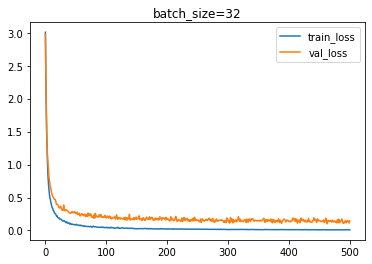

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title('batch_size=32')
plt.legend()
plt.show()

In [ ]:

batchSize_candidate = [100,50,20,10] 
learningRate_candidate = [1e-3,1e-2,1e-1]

epochs_ = 500
batchSize_ = 32
learningRate_ = 1e-2

trainer = Trainer(epochs_, batchSize_, learningRate_)
trainer.train()

# tester = Tester(batchSize_)
# tester.test()

'''
for batchSize in batchSize_candidate:
    for learningRate in learningRate_candidate:
        x_data, y_data = trainer.return_whole_training_img()

        validation_loss = 0
        skf = StratifiedKFold(n_splits=6)
        for train_index, validate_index in skf.split(x_data, y_data): 
            cross_train_x = []
            cross_train_y = []
            cross_validate_x = []
            cross_validate_y = []

            for i in train_index:
                cross_train_x.append(x_data[i])
                cross_train_y.append(y_data[i])
            for j in validate_index:
                cross_validate_x.append(x_data[j])
                cross_validate_y.append(y_data[j])

            cross_trainer = Cross_Validator(1, batchSize, learningRate, cross_train_x, cross_train_y)
            cross_trainer.train()
            cross_validator = Cross_Validator(1, batchSize, learningRate, cross_validate_x, cross_validate_y)
            cross_validator.validate()

            validation_loss += cross_validator.loss

        print('batchsize: %d, learning rate: %f' %(batchSize, learningRate))
        print('Average loss in the 6-fold cross validation: ', validation_loss/ 5)
'''

Finish build model.



weightPATH:  /content/gdrive/My Drive/computer vision/
Training...


epoch  0
training loss: 14.036537647247314, val loss: 2.9757880369822183
epoch  1
training loss: 9.682321071624756, val loss: 2.087552030881246
epoch  2
training loss: 6.975217700004578, val loss: 1.589038372039795
epoch  3
training loss: 5.308124125003815, val loss: 1.2199838558832805
epoch  4
training loss: 4.039963225523631, val loss: 1.055292268594106
epoch  5
training loss: 3.296378493309021, val loss: 0.9241562883059183
epoch  6
training loss: 2.812627067168554, val loss: 0.7996728618939718
epoch  7
training loss: 2.3796679178873696, val loss: 0.7375571032365164
epoch  8
training loss: 2.2229826351006827, val loss: 0.6649348735809326
epoch  9
training loss: 1.9778855790694554, val loss: 0.6331746677557627
epoch  10
training loss: 1.7794400602579117, val loss: 0.5805906156698862
epoch  11
training loss: 1.636063704888026, val loss: 0.5420761704444885
epoch  12
training loss: 1.539137378334999, val loss: 0.5142388542493185
epoch  13
training loss: 1.3988041579723358, val loss: 0.50

"\nfor batchSize in batchSize_candidate:\n    for learningRate in learningRate_candidate:\n        x_data, y_data = trainer.return_whole_training_img()\n\n        validation_loss = 0\n        skf = StratifiedKFold(n_splits=6)\n        for train_index, validate_index in skf.split(x_data, y_data): \n            cross_train_x = []\n            cross_train_y = []\n            cross_validate_x = []\n            cross_validate_y = []\n\n            for i in train_index:\n                cross_train_x.append(x_data[i])\n                cross_train_y.append(y_data[i])\n            for j in validate_index:\n                cross_validate_x.append(x_data[j])\n                cross_validate_y.append(y_data[j])\n\n            cross_trainer = Cross_Validator(1, batchSize, learningRate, cross_train_x, cross_train_y)\n            cross_trainer.train()\n            cross_validator = Cross_Validator(1, batchSize, learningRate, cross_validate_x, cross_validate_y)\n            cross_validator.validate()\

In [ ]:
class Cross_Validator(object):
    def __init__(self, epochs, batch_size, learning_rate, x_data, y_data):
        self.batch_size = batch_size
        #self.epochs = epochs
        self._build_model()
        self.learning_rate = learning_rate
        self.correct = 0
        self.validation_loss = []
        self.loss = 0
        self.x_data = x_data
        self.y_data = y_data

        self.weight_PATH = '/content/gdrive/My Drive/'
        print("Validating...")

    def _build_model(self):
        resnet = net
        self.resnet = resnet.to(device)
        print('Finish build model.')

    def train(self):
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.resnet.parameters(), lr=self.learning_rate)
        self.losses = []

        iteration = len(self.x_data) // self.batch_size              

        idx = 0
        train_loss = 0
        for p in range(iteration):
            optimizer.zero_grad()
            x_mini_batch = np.full((self.batch_size, 3, 224, 224), 0, dtype=np.float32)
            y_mini_batch = np.full((self.batch_size), 0, dtype=np.int_)

            for q in range(self.batch_size):
                x_mini_batch[q] = self.x_data[idx].detach().cpu().numpy()
                y_mini_batch[q] = self.y_data[idx]
                idx+=1

            result_resnet = self.resnet(torch.from_numpy(x_mini_batch).cuda()).cpu()
         
            loss = loss_func(result_resnet, torch.from_numpy(y_mini_batch))

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        self.losses.append(train_loss)

        #plt.plot(self.losses)
        #plt.xlabel('epoch')
        #plt.ylabel('Validation Loss While training')
        #plt.show()

        torch.save(self.resnet.state_dict(), "".join([self.weight_PATH,'cross_validation_param.pth']))
        

    def validate(self):
        self.resnet.load_state_dict(torch.load(self.weight_PATH + 'cross_validation_param.pth'))

        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.resnet.parameters(), lr=self.learning_rate)
       
        validation_loss = 0
        iteration = len(self.x_data) // self.batch_size
        idx = 0

        for p in range(iteration):
            x_mini_batch = np.full((self.batch_size, 3, 224, 224), 0, dtype=np.float32)
            y_mini_batch = np.full((self.batch_size), 0, dtype=np.int_)

            for q in range(self.batch_size):
                x_mini_batch[q] = self.x_data[idx].detach().cpu().numpy()
                y_mini_batch[q] = self.y_data[idx]
                idx+=1

            result_resnet = self.resnet(torch.from_numpy(x_mini_batch).cuda()).cpu()
            loss = loss_func(result_resnet, torch.from_numpy(y_mini_batch))
            validation_loss += loss.item()
        

        print('validation loss in this fold: ', validation_loss)
        self.loss = validation_loss
        